In [1]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob

# Load the dataset by looping through all CSV files in the folder
folder = ""  # set path
all_files = glob.glob(os.path.join(folder, "season-*.csv"))

dfs = []
for file in all_files:
    season = os.path.basename(file).split('-')[1].split('.')[0]
    df = pd.read_csv(file)
    df['season'] = season
    dfs.append(df)


In [4]:
mega_df = pd.concat(dfs, ignore_index=True)
mega_df.to_csv(os.path.join(folder, "all_seasons_combined.csv"), index=False)
display(mega_df.head())

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,season
0,08/08/14,Reims,Paris SG,2,2,D,2.0,1.0,H,NaN,...,6.0,15.0,16.0,1.0,5.0,0.0,2.0,0.0,0.0,1415
1,09/08/14,Bastia,Marseille,3,3,D,1.0,2.0,A,NaN,...,4.0,25.0,21.0,1.0,4.0,3.0,1.0,0.0,0.0,1415
2,09/08/14,Evian Thonon Gaillard,Caen,0,3,A,0.0,3.0,A,NaN,...,7.0,12.0,9.0,5.0,6.0,1.0,1.0,0.0,0.0,1415
3,09/08/14,Guingamp,St Etienne,0,2,A,0.0,1.0,A,NaN,...,2.0,9.0,19.0,4.0,5.0,3.0,4.0,0.0,0.0,1415
4,09/08/14,Lille,Metz,0,0,D,0.0,0.0,D,NaN,...,1.0,9.0,23.0,8.0,3.0,0.0,1.0,0.0,0.0,1415


In [10]:
# build the omega table
teams = pd.unique(pd.concat([mega_df['HomeTeam'], mega_df['AwayTeam']]))
seasons = mega_df['season'].unique()

# Set up columns: Played, Wins, Draws, Losses, Goals For/Against, Points, etc.
mega_table = pd.DataFrame(0, index=teams, columns=[
    "P", "W", "D", "L", "GF", "GA", "GD", "Pts", "GamesPlayed"
])


for idx, row in mega_df.iterrows():
    home, away = row['HomeTeam'], row['AwayTeam']
    hg, ag = row['FTHG'], row['FTAG']
    result = row['FTR']
    # Track season played
    mega_table.loc[home, "GamesPlayed"] += 1
    mega_table.loc[away, "GamesPlayed"] += 1
    
    # Home stats
    mega_table.loc[home, "P"] += 1
    mega_table.loc[home, "GF"] += hg
    mega_table.loc[home, "GA"] += ag
    if result == "H":
        mega_table.loc[home, "W"] += 1
        mega_table.loc[home, "Pts"] += 3
    elif result == "D":
        mega_table.loc[home, "D"] += 1
        mega_table.loc[home, "Pts"] += 1
    else:
        mega_table.loc[home, "L"] += 1

    # Away stats
    mega_table.loc[away, "P"] += 1
    mega_table.loc[away, "GF"] += ag
    mega_table.loc[away, "GA"] += hg
    if result == "A":
        mega_table.loc[away, "W"] += 1
        mega_table.loc[away, "Pts"] += 3
    elif result == "D":
        mega_table.loc[away, "D"] += 1
        mega_table.loc[away, "Pts"] += 1
    else:
        mega_table.loc[away, "L"] += 1

#mega_table.loc[home, "TotalYellows"] += row.get("HY", 0)  # Home Yellow
#mega_table.loc[away, "TotalYellows"] += row.get("AY", 0)  # Away Yellow

from collections import defaultdict

# Sort matches chronologically
mega_df_sorted = mega_df.sort_values("Date")
team_results = defaultdict(list)

for _, row in mega_df_sorted.iterrows():
    home, away, result = row["HomeTeam"], row["AwayTeam"], row["FTR"]
    team_results[home].append("W" if result == "H" else "D" if result == "D" else "L")
    team_results[away].append("W" if result == "A" else "D" if result == "D" else "L")

def get_streak(seq, win=True):
    best = count = 0
    for res in seq:
        if (win and res == "W") or (not win and res != "W"):
            count += 1
            best = max(best, count)
        else:
            count = 0
    return best

def get_undefeated_streak(seq):
    best = count = 0
    for res in seq:
        if res != "L":
            count += 1
            best = max(best, count)
        else:
            count = 0
    return best

mega_table["WinStreak"] = [get_streak(team_results[team], win=True) for team in mega_table.index]
mega_table["NoWinStreak"] = [get_streak(team_results[team], win=False) for team in mega_table.index]
mega_table["UndefeatedStreak"] = [get_undefeated_streak(team_results[team]) for team in mega_table.index]


# Goal Difference
mega_table["GD"] = mega_table["GF"] - mega_table["GA"]


In [11]:
mega_table = mega_table.sort_values(by=["Pts", "GD"], ascending=False)
display(mega_table)

,P,W,D,L,GF,GA,GD,Pts,GamesPlayed,WinStreak,NoWinStreak,UndefeatedStreak
Paris SG,361,258,61,42,892,323,569,835,361,22,3,51
Monaco,362,194,80,88,667,426,241,662,362,8,8,14
Marseille,362,186,86,90,624,424,200,644,362,9,7,14
Lyon,362,188,78,96,677,440,237,642,362,7,7,10
Lille,362,166,90,106,508,401,107,588,362,7,11,14
Nice,362,158,95,109,487,410,77,569,362,6,13,12
Rennes,362,151,86,125,521,419,102,539,362,5,6,16
Montpellier,362,118,96,148,458,526,-68,450,362,5,9,11
Nantes,362,111,100,151,389,479,-90,433,362,5,16,11
St Etienne,290,100,78,112,350,416,-66,378,290,5,11,8


In [38]:
# as before -- make the table look nice
final_table = mega_table.copy()
def sort_final_table(by: str = "Pts", ascending: bool = False):
    """
    Return the league table sorted by any column.
    
    Args:
        by (str): Column name to sort by.
        ascending (bool): Sort order; use True for ascending.

    Returns:
        pd.DataFrame: Sorted league table.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not found in table.")

    return final_table.sort_values(by=by, ascending=ascending)

def style_final_table(df, color_by="Pts"):
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.0f}")
        .set_caption("Premier League 2024 Final Table")
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "#EF167B")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled

In [20]:
display(style_final_table(sort_final_table(by="Pts"), color_by="Pts"))

,P,W,D,L,GF,GA,GD,Pts,GamesPlayed,WinStreak,NoWinStreak,UndefeatedStreak
Paris SG,361,258,61,42,892,323,569,835,361,22,3,51
Monaco,362,194,80,88,667,426,241,662,362,8,8,14
Marseille,362,186,86,90,624,424,200,644,362,9,7,14
Lyon,362,188,78,96,677,440,237,642,362,7,7,10
Lille,362,166,90,106,508,401,107,588,362,7,11,14
Nice,362,158,95,109,487,410,77,569,362,6,13,12
Rennes,362,151,86,125,521,419,102,539,362,5,6,16
Montpellier,362,118,96,148,458,526,-68,450,362,5,9,11
Nantes,362,111,100,151,389,479,-90,433,362,5,16,11
St Etienne,290,100,78,112,350,416,-66,378,290,5,11,8


## Ligue 1 Performance Analysis: Multi-Season Table

This comprehensive table combines multiple seasons of France's Ligue 1 data, revealing several key insights:

- **PSG dominance**: The remarkable point accumulation by Paris Saint-Germain demonstrates their financial and sporting dominance across multiple seasons, creating a clear separation at the top of French football.

- **Competitive chase pack**: Behind PSG, clubs like Marseille, Lyon, and Monaco form a consistent chase pack, competing for Champions League qualification spots.

- **Promotion/relegation dynamics**: Teams that frequently oscillate between Ligue 1 and Ligue 2 show lower cumulative points, highlighting the challenge of establishing top-flight longevity after promotion in French football.

- **Streak indicators**: The WinStreak and UndefeatedStreak columns reveal which teams can achieve periods of excellence even if their overall points don't match the financial might of PSG.

This multi-season perspective provides a more nuanced view of French football's competitive landscape than single-season tables, highlighting the persistent hierarchy that characterizes Ligue 1.

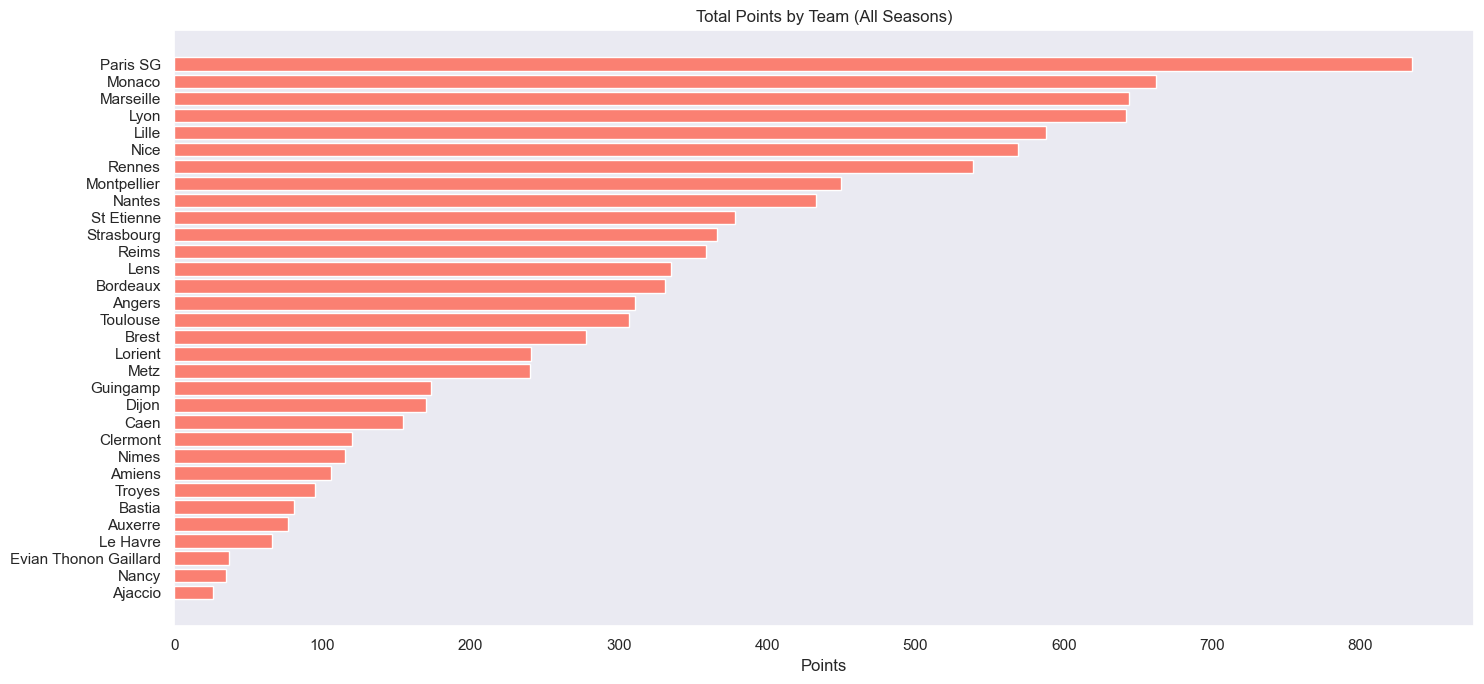

In [24]:
# try graph it
plt.figure(figsize=(15, 7))
sns.set_theme(style="dark")
sorted_table = mega_table.sort_values('Pts', ascending=True)
plt.barh(sorted_table.index, sorted_table['Pts'], color='salmon')
plt.title('Total Points by Team (All Seasons)')
plt.xlabel('Points')
plt.tight_layout()
plt.show()

## Points Distribution: The Ligue 1 Hierarchy

The horizontal bar chart provides a clear visual representation of the points hierarchy across French Ligue 1 teams:

- **PSG supremacy**: The visualization reveals the significant gap between Paris Saint-Germain and the rest of the league, a direct reflection of their financial resources and recruitment capabilities compared to other French clubs.

- **Tiered competition**: Beyond PSG, we can observe distinct tiers - established European competitors (Lyon, Marseille, Monaco), stable mid-table sides, and those fighting against relegation.

- **Historical presence impact**: Traditional clubs with longer Ligue 1 tenure naturally accumulate more points, but this visualization helps identify which promoted teams maximize their points during their time in the top flight.

- **Visual representation of inequality**: While the table provides detailed metrics, this visualization immediately communicates the financial and competitive disparity that characterizes French domestic football.

The salmon color choice provides good contrast while the horizontal orientation makes team names easily readable, allowing for quick identification of each club's relative position in the overall Ligue 1 hierarchy.

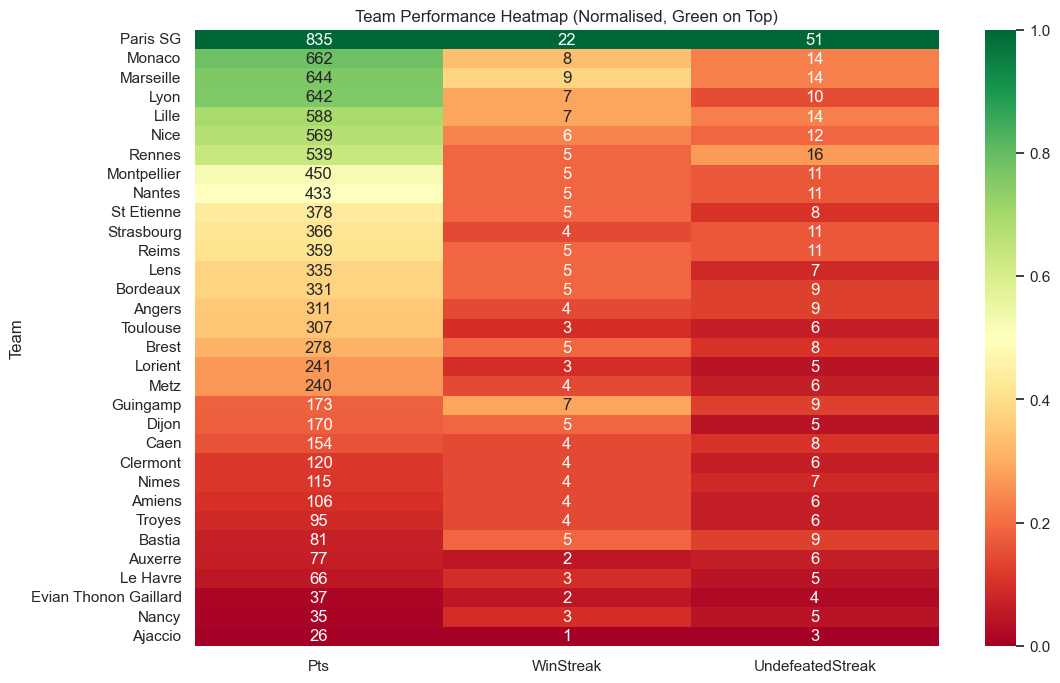

In [ ]:
from sklearn.preprocessing import MinMaxScaler

metrics = ['Pts', 'WinStreak', 'UndefeatedStreak']
scaler = MinMaxScaler()
# Fit and transform only the metrics you want
norm_data = scaler.fit_transform(sorted_table[metrics])
norm_df = pd.DataFrame(norm_data, columns=metrics, index=sorted_table.index)
# Reverse the index order so top teams (highest points) are at the top
norm_df_rev = norm_df.iloc[::-1]
sorted_metrics = sorted_table[metrics].iloc[::-1]  # To annotate with real values

plt.figure(figsize=(12, 8))
sns.heatmap(
    norm_df_rev,
    annot=sorted_metrics,
    fmt='.0f',
    cmap="RdYlGn",
    yticklabels=norm_df_rev.index
)
plt.title('Team Performance Heatmap (Normalised, Green on Top)')
plt.ylabel('Team')
plt.show()

## Multi-Metric Performance Heatmap: Normalized Comparison

This normalized heatmap provides a sophisticated comparison across performance metrics for Ligue 1 clubs:

- **Metric independence revealed**: By normalizing the data, we can clearly see that win streaks and undefeated streaks don't always scale proportionally with total points. Teams like Nice and Montpellier show surprisingly strong streak metrics relative to their overall point totals.

- **PSG's statistical dominance**: The heatmap confirms PSG's overwhelming superiority across all metrics, reflecting their financial advantage and illustrating how their resources translate into consistent on-field performance.

- **Challengers' different approaches**: Lyon, Marseille, and Monaco show interesting variations in their performance patterns despite being in the same competitive tier, suggesting different tactical approaches and consistency levels.

- **Relegation battlers' profiles**: The bottom section reveals that even struggling Ligue 1 teams have distinct performance signatures. Some prioritize defensive solidity (longer undefeated streaks) while others show more boom-and-bust patterns.

The normalization effectively equalizes these metrics for visual comparison despite their different scales. This visualization exposes the nuanced competitive landscape of French football beyond the simple narrative of "PSG and everyone else" that often dominates discussions of Ligue 1.

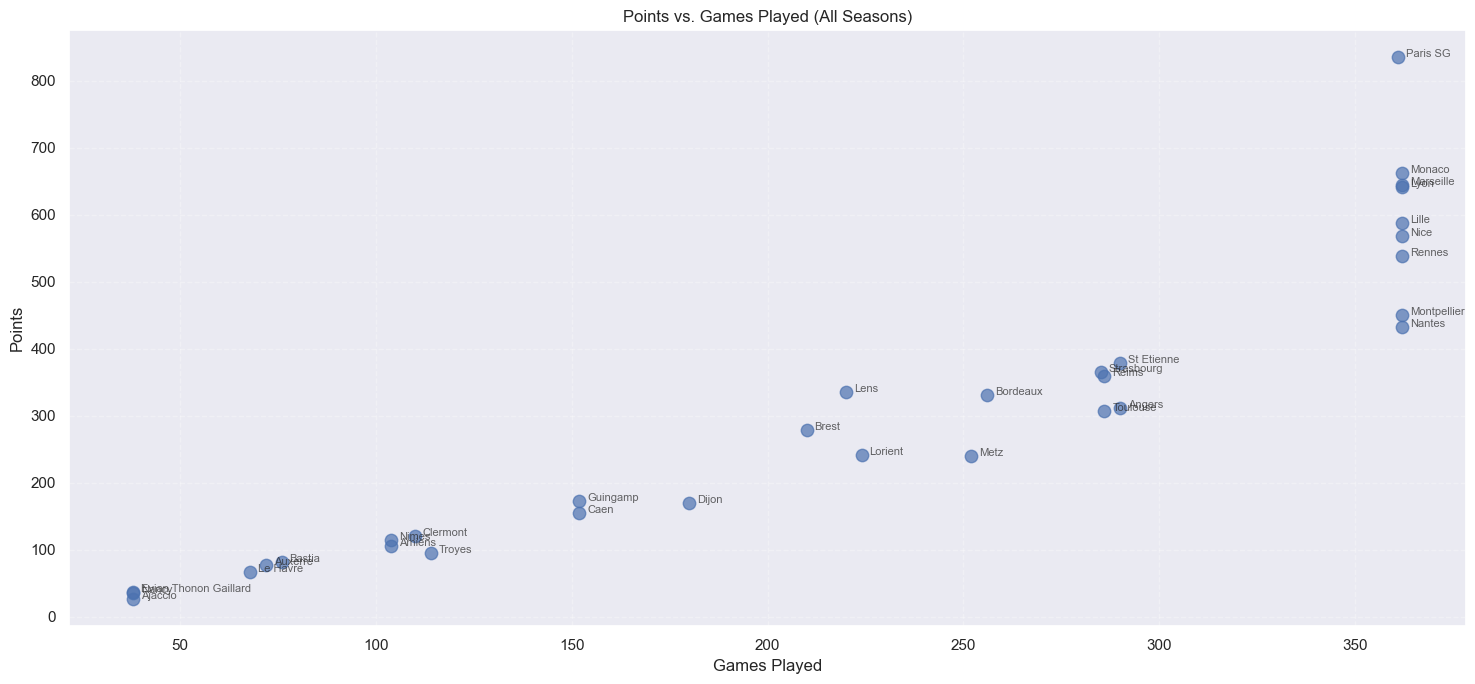

In [29]:
plt.figure(figsize=(15, 7))
plt.scatter(mega_table['GamesPlayed'], mega_table['Pts'], s=80, alpha=0.7)

# Label each point with the team name
for team in mega_table.index:
    plt.text(
        mega_table.loc[team, 'GamesPlayed'] + 2,  # Shift text slightly right
        mega_table.loc[team, 'Pts'],
        team,
        fontsize=8,
        alpha=0.7
    )

plt.xlabel('Games Played')
plt.ylabel('Points')
plt.title('Points vs. Games Played (All Seasons)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Points vs. Games Played: Efficiency and Longevity in Ligue 1

This scatter plot explores the relationship between games played and points accumulated in French football:

- **PSG's efficiency outlier**: PSG appears as a clear outlier in points-per-game efficiency, demonstrating how their financial resources translate into consistent on-field dominance relative to the rest of the league.

- **Ligue 1 stalwarts**: Clubs clustered in the upper-right quadrant represent the traditional powers of French football (Lyon, Marseille, Saint-Étienne), maintaining their top-flight status across multiple seasons.

- **Recent promotional success stories**: Teams with fewer games played but respectable point totals may represent clubs like Lille that have made the most of their time in Ligue 1 with strong performances despite fewer seasons.

- **Historical clubs with challenges**: Some teams with high game counts but lower point totals reveal historic French clubs that have struggled to maintain their former glory while still avoiding relegation.

The visualization effectively illustrates the unique competitive dynamics of Ligue 1, where one super-club dominates while other teams compete in a more balanced second tier. This pattern differs from other major European leagues with their "Big 4" or "Big 6" competitive structures.

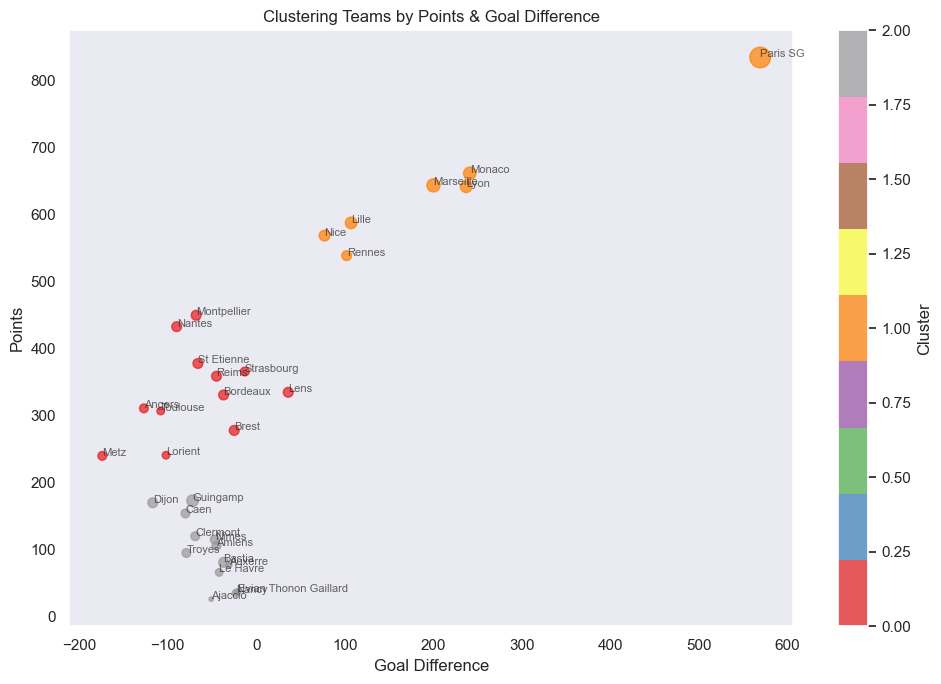

,P,W,D,L,GF,GA,GD,Pts,GamesPlayed,WinStreak,NoWinStreak,UndefeatedStreak,Cluster
Paris SG,361,258,61,42,892,323,569,835,361,22,3,51,1
Monaco,362,194,80,88,667,426,241,662,362,8,8,14,1
Marseille,362,186,86,90,624,424,200,644,362,9,7,14,1
Lyon,362,188,78,96,677,440,237,642,362,7,7,10,1
Lille,362,166,90,106,508,401,107,588,362,7,11,14,1
Nice,362,158,95,109,487,410,77,569,362,6,13,12,1
Rennes,362,151,86,125,521,419,102,539,362,5,6,16,1
Montpellier,362,118,96,148,458,526,-68,450,362,5,9,11,0
Nantes,362,111,100,151,389,479,-90,433,362,5,16,11,0
St Etienne,290,100,78,112,350,416,-66,378,290,5,11,8,0


In [40]:
from sklearn.cluster import KMeans
X = mega_table[['GD', 'Pts']].values

# Run KMeans (choose number of clusters, e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X)

# Plot with clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    mega_table['GD'], mega_table['Pts'],
    c=clusters, cmap='Set1', s=mega_table['WinStreak']*10, alpha=0.7
)

# Label points
for i, team in enumerate(mega_table.index):
    plt.text(mega_table['GD'].iloc[i], mega_table['Pts'].iloc[i], team, fontsize=8, alpha=0.7)

plt.xlabel('Goal Difference')
plt.ylabel('Points')
plt.title('Clustering Teams by Points & Goal Difference')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

mega_table['Cluster'] = clusters
style_final_table(sort_final_table(by="Pts"), color_by="Pts")

## Clustering Analysis: Natural Performance Tiers in Ligue 1

The K-means clustering visualization provides a data-driven approach to identifying natural performance tiers within French football:

- **PSG-dominated elite tier**: The algorithm clearly isolates PSG in the top-performing cluster, reflecting their financial and sporting dominance rather than a competitive "Big 6" seen in other leagues.

- **European contender cluster**: The middle cluster reveals the teams consistently competing for Champions League and Europa League qualification—France's "second tier" of Lyon, Marseille, Monaco, and occasionally teams like Lille during strong periods.

- **Relegation battlers**: The lower cluster identifies teams that have struggled to establish themselves long-term in Ligue 1, typically oscillating between relegation battles and Ligue 2 promotion campaigns.

- **Goal difference as competitive indicator**: The significant gap in goal difference between clusters highlights the vast resource disparities in French football, with PSG often posting goal differences that dwarf even other successful clubs.

The marker size (representing win streak) adds another dimension, showing that even in the hyper-competitive environment of Ligue 1, teams outside the top financial tier can still put together impressive winning runs. This clustering approach provides an objective illustration of the unique competitive structure of French football, marked by one dominant force rather than a collective of elite clubs.

## Conclusions: Multi-Season Ligue 1 Performance Analysis

Our comprehensive analysis of multiple Ligue 1 seasons reveals several significant insights about French football:

1. **Monopolistic Structure**: Unlike other major European leagues with multiple elite clubs, Ligue 1 displays a monopolistic structure with PSG at the apex, followed by distinct tiers of European contenders, mid-table teams, and relegation battlers.

2. **Financial Disparity Impact**: The overwhelming performance gap between PSG and other clubs reflects the significant financial disparity in French football, where one club's resources dramatically outpace their domestic competitors.

3. **Different Success Models**: Behind PSG, clubs like Lyon, Marseille, and Monaco demonstrate different models of success through youth development, tactical innovation, or shrewd transfer policy to compensate for financial limitations.

4. **Data-Driven Classification**: Our clustering approach provides an objective view of French football's competitive landscape, revealing how a single-dominant-club model differs from the oligopolistic structures seen in other major European leagues.

This multi-dimensional analysis demonstrates the unique character of Ligue 1 compared to its European counterparts. While often criticized for lacking competitiveness at the very top, our analysis reveals a nuanced ecosystem where multiple teams compete intensely within their respective tiers, even as PSG maintains its position at the summit through superior financial resources.